During this data analysis, a dataset of online shopping website activity (each row representing details about one user while being on the website) will be extracted from RDS database, cleaned using various statistical methods, then will be analysed to answer some questions which will contribute to make informed decisions about changes to the website and marketing strategies.

Import required packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Import required modules:

In [2]:
import db_utils
import datatype_transform
import dataframe_transform
import dataframe_info
import plotter

Import data from RDS database:

In [3]:
customer_activity_class = db_utils.RDSDatabaseConnector(db_utils.yaml_dictionary)
engine = customer_activity_class.connect_database()
customer_activity = customer_activity_class.extract_data(engine)

Convert data types:

In [4]:
# Get the data type for each column
print('Data types before the transformation:')
print(customer_activity.dtypes)
         
# Covert data types for some columns to category 
customer_activity_DataTransform = datatype_transform.DatatypeTransform(customer_activity)
columns_to_transform = ['administrative', 'product_related', 'informational', 
                        'month', 'operating_systems', 'browser', 'region', 
                        'traffic_type', 'visitor_type']
for column in columns_to_transform:
    customer_activity_DataTransform.convert_to_category(column)
    
# Check if the columns have been transformed correctly  
print('\n')  
print('Data types after the transformation:')
print(customer_activity.dtypes)

Data types before the transformation:
administrative              float64
administrative_duration     float64
informational                 int64
informational_duration      float64
product_related             float64
product_related_duration    float64
bounce_rates                float64
exit_rates                  float64
page_values                 float64
month                        object
operating_systems            object
browser                      object
region                       object
traffic_type                 object
visitor_type                 object
weekend                        bool
revenue                        bool
dtype: object


Data types after the transformation:
administrative              category
administrative_duration      float64
informational               category
informational_duration       float64
product_related             category
product_related_duration     float64
bounce_rates                 float64
exit_rates                   float64
p

Following columns have been converted to category data type:
- administrative
- informational
- product_related
- month
- operating_systems
- browser
- region
- traffic_type
- visitor_type

Put columns into different groups based on data types:

In [5]:
all_columns = customer_activity.columns
numeric_columns = ['administrative_duration', 'informational_duration', 'product_related_duration',
                   'bounce_rates', 'exit_rates', 'page_values']
categorical_columns = ['administrative', 'informational', 'product_related', 'month',
                       'operating_systems', 'browser', 'region', 'visitor_type']
boolean_columns = ['weekend', 'revenue']

Create instances of the classes:

In [6]:
customer_activity_info = dataframe_info.DataFrameInfo(customer_activity)
customer_activity_plot = plotter.Plotter(customer_activity)
customer_activity_transform = dataframe_transform.DataFrameTransform(customer_activity)

Get statistical summaries for numeric columns:

In [7]:
customer_activity_info.get_description()

# Get median as well
for column in numeric_columns:
    customer_activity_info.get_median(column)

Description for numeric columns:
       administrative_duration  informational_duration  \
count             11418.000000            11994.000000   
mean                 84.539079               34.486687   
std                 179.392485              136.201557   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%                   6.000000                0.000000   
75%                  95.000000                0.000000   
max                2155.000000             1988.750000   

       product_related_duration  bounce_rates    exit_rates   page_values  
count              12129.000000  12330.000000  12330.000000  12330.000000  
mean                1192.426086      0.022381      0.042820      5.556310  
std                 1767.243802      0.048847      0.048578     17.397345  
min                    0.000000      0.000000      0.000000      0.000000  
25%                  192.000000      0.000000      0.014000     

For categorical columns, get distinct count values for each column and plot bar charts:

Counts for distinct values for administrative
0.0     5644
1.0     1237
2.0     1018
3.0      885
4.0      661
5.0      541
6.0      401
7.0      314
8.0      259
9.0      227
10.0     165
11.0      97
12.0      93
13.0      65
14.0      42
15.0      37
16.0      25
17.0      15
18.0      14
19.0       5
21.0       5
23.0       4
24.0       4
20.0       2
Name: count, dtype: int64


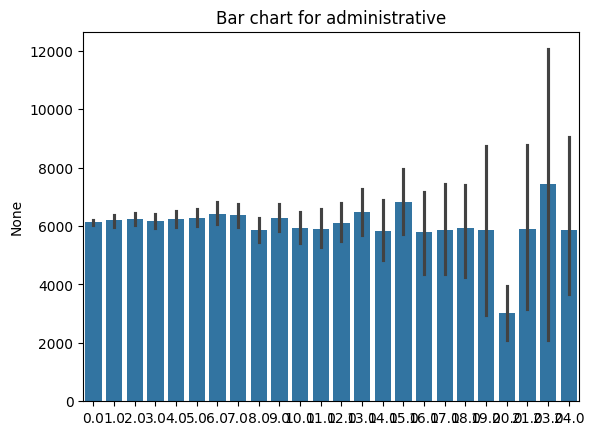

Counts for distinct values for informational
0     9595
1     1105
2      763
3      426
4      215
5      101
6       74
7       26
8       12
9        6
12       4
10       2
11       1
Name: count, dtype: int64


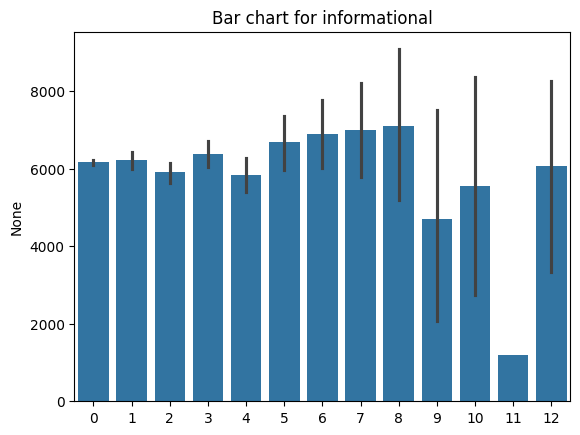

Counts for distinct values for product_related
1.0      582
2.0      426
3.0      422
5.0      385
6.0      378
        ... 
278.0      1
279.0      1
282.0      1
291.0      1
485.0      1
Name: count, Length: 296, dtype: int64


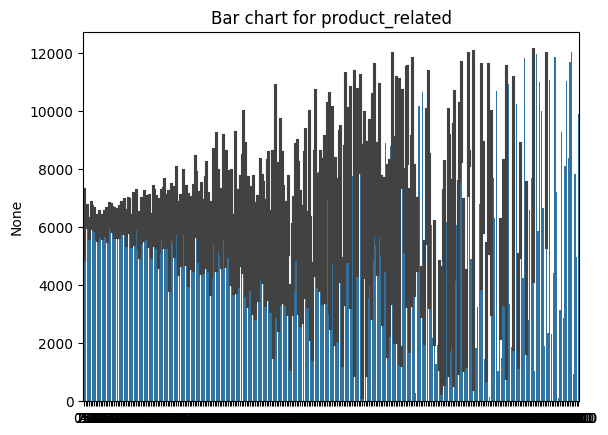

Counts for distinct values for month
May     3332
Nov     2959
Dec     1828
Mar     1807
Oct      598
Sep      462
Aug      457
Jul      441
June     247
Feb      199
Name: count, dtype: int64


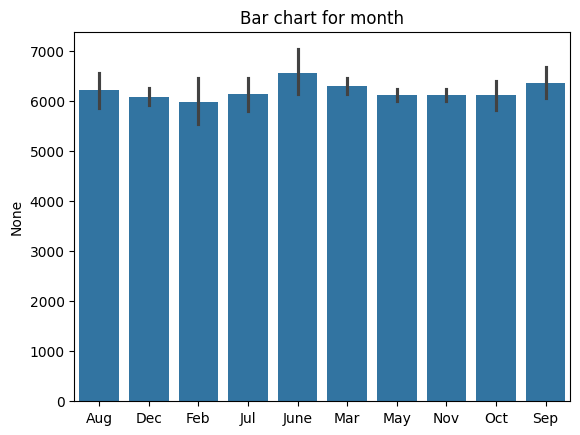

Counts for distinct values for operating_systems
Windows     6596
MACOS       2676
Android     2584
iOS          385
ChromeOS      62
Ubuntu         9
Other          7
Name: count, dtype: int64


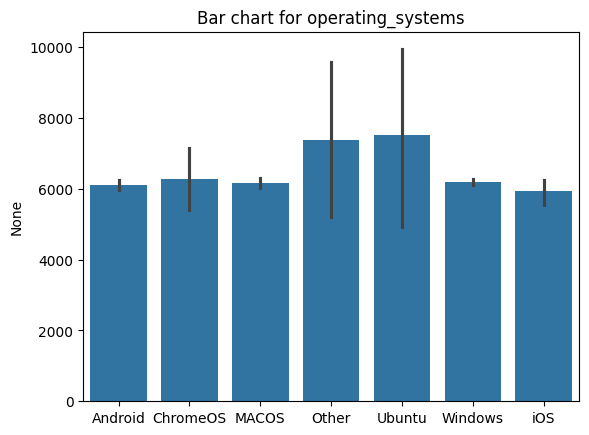

Counts for distinct values for browser
Google Chrome        7721
Safari               2527
Mozilla Firefox       830
Microsoft Edge        582
Internet Explorer     156
Samsung Internet      145
Opera                 136
Android               121
QQ                     53
Sogou Explorer         47
Yandex                  8
UC Browser              2
Undetermined            2
Name: count, dtype: int64


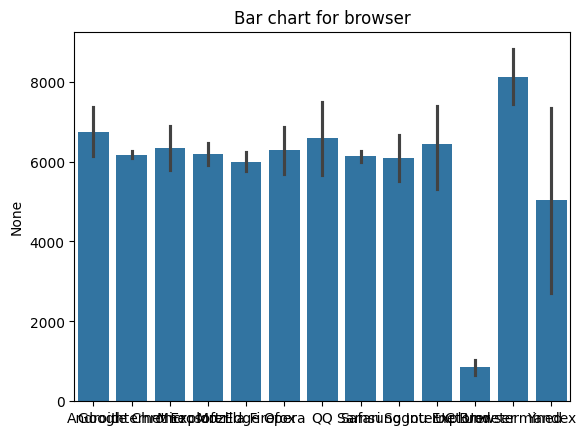

Counts for distinct values for region
North America      4869
Western Europe     2283
Eastern Europe     1154
Asia               1143
South America       913
Africa              770
Northern Africa     499
Southern Africa     423
Oceania             276
Name: count, dtype: int64


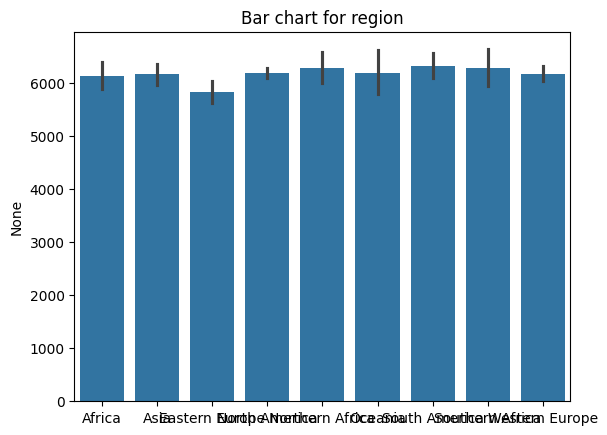

Counts for distinct values for visitor_type
Returning_Visitor    10691
New_Visitor           1570
Other                   69
Name: count, dtype: int64


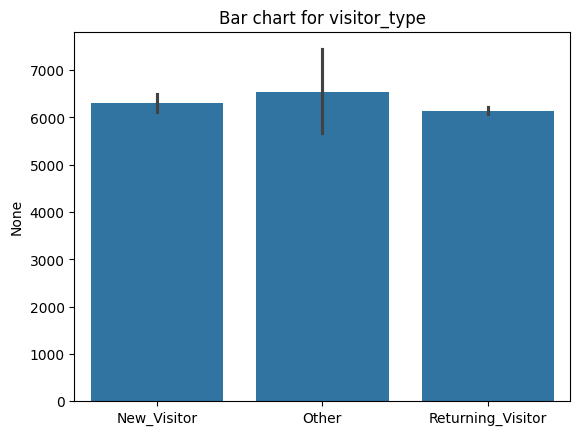

In [8]:
for column in categorical_columns:
    customer_activity_info.get_counts(column)
    customer_activity_plot.plot_barchart(column)    

Get the information for the amount of missing values in each column:

In [9]:
for column in all_columns:
    customer_activity_info.get_NULL_counts(column)

Number of NULLs for administrative: 570
Percentage of NULLs for administrative: 4.62 %
Number of NULLs for administrative_duration: 912
Percentage of NULLs for administrative_duration: 7.4 %
Number of NULLs for informational: 0
Percentage of NULLs for informational: 0.0 %
Number of NULLs for informational_duration: 336
Percentage of NULLs for informational_duration: 2.73 %
Number of NULLs for product_related: 579
Percentage of NULLs for product_related: 4.7 %
Number of NULLs for product_related_duration: 201
Percentage of NULLs for product_related_duration: 1.63 %
Number of NULLs for bounce_rates: 0
Percentage of NULLs for bounce_rates: 0.0 %
Number of NULLs for exit_rates: 0
Percentage of NULLs for exit_rates: 0.0 %
Number of NULLs for page_values: 0
Percentage of NULLs for page_values: 0.0 %
Number of NULLs for month: 0
Percentage of NULLs for month: 0.0 %
Number of NULLs for operating_systems: 11
Percentage of NULLs for operating_systems: 0.09 %
Number of NULLs for browser: 0
Percen

Following columns contain missing values:
- administrative
- administrative_duration
- informational_duration
- product_related
- product_related_duration
- operating_systems

For categorical columns (administrative, product_realted, and operating_systems),
mode imputation will be used.
For numeric columns (administrative_duration, informational_duration, and product_related_duration) if
it is skewed median imputation will be used and if it is symmetrical mean 
imputation will be used.

Check the skewness for these three numeric columns with missing values:

In [10]:
numeric_columns_missing_values = ['administrative_duration', 'informational_duration', 'product_related_duration']
for column in numeric_columns_missing_values:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 4.67
Skew of informational_duration is 7.2
Skew of product_related_duration is 3.64


They are all right skewed so median imputation will be conducted:

In [11]:
# Compute median imputation for the numeric columns with missing values
for column in numeric_columns_missing_values:
    customer_activity_transform.median_impute(column)
    
# Compute mode imputation for the categorical columns with missing values
categorical_columns_missing_values = ['administrative', 'product_related', 'operating_systems']
for column in categorical_columns_missing_values:
    customer_activity_transform.mode_impute(column)
    
# Check if the imputation has been successful
columns_missing_values = numeric_columns_missing_values + categorical_columns_missing_values
for column in columns_missing_values:
    customer_activity_info.get_NULL_counts(column)

Number of NULLs for administrative_duration: 0
Percentage of NULLs for administrative_duration: 0.0 %
Number of NULLs for informational_duration: 0
Percentage of NULLs for informational_duration: 0.0 %
Number of NULLs for product_related_duration: 0
Percentage of NULLs for product_related_duration: 0.0 %
Number of NULLs for administrative: 0
Percentage of NULLs for administrative: 0.0 %
Number of NULLs for product_related: 0
Percentage of NULLs for product_related: 0.0 %
Number of NULLs for operating_systems: 0
Percentage of NULLs for operating_systems: 0.0 %


Get information for skewness for all numeric columns:

In [12]:
for column in numeric_columns:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 4.84
Skew of informational_duration is 7.3
Skew of product_related_duration is 3.68
Skew of bounce_rates is 2.95
Skew of exit_rates is 2.19
Skew of page_values is 6.02


Plot histograms to visualise the skewness:

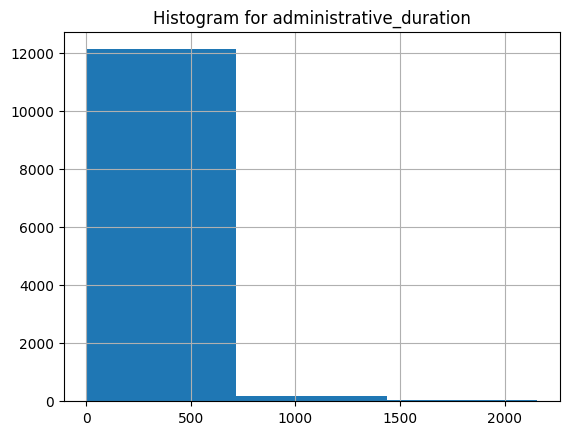

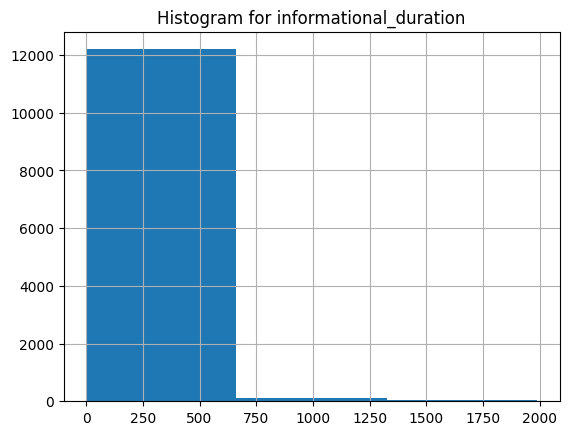

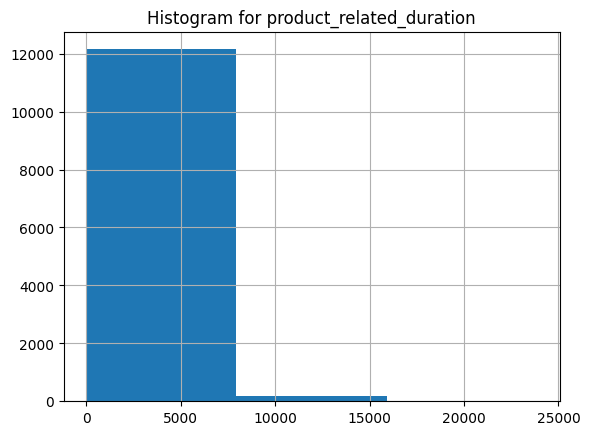

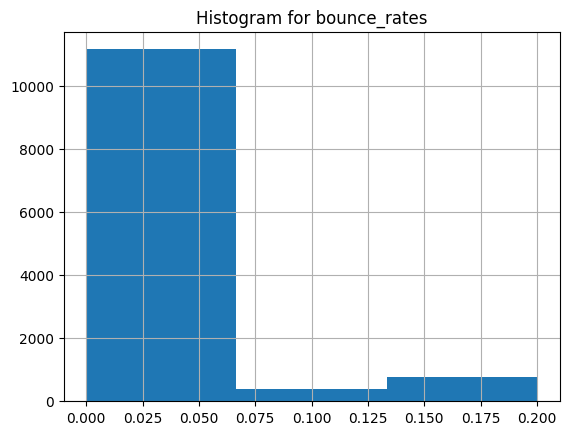

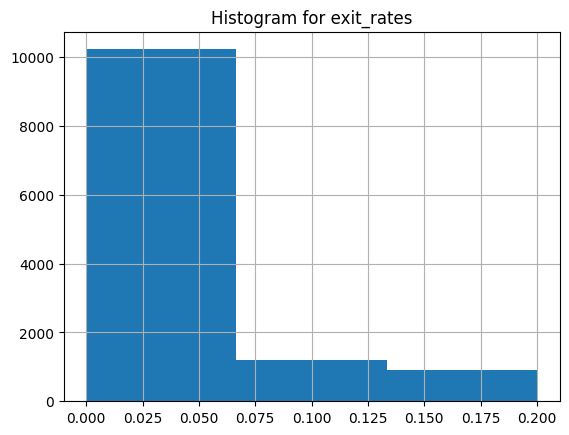

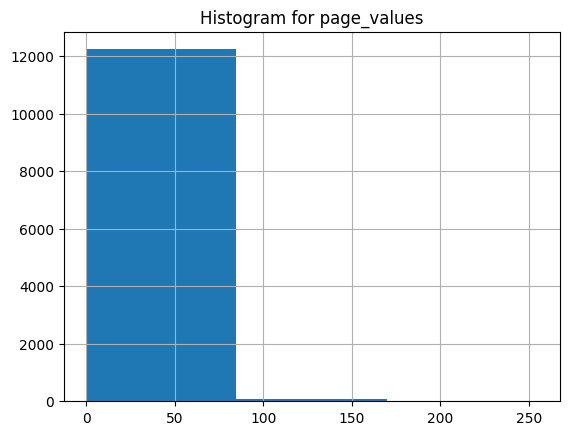

In [13]:
for column in numeric_columns:
    customer_activity_plot.plot_histograms(column)

Conduct Yeo-Johnson transform on the numeric columns:

In [14]:
for column in numeric_columns:
    customer_activity_transform.yeo_johnson_transform(column)
    
# Check the skewness again
for column in numeric_columns:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 0.16
Skew of informational_duration is 1.51
Skew of product_related_duration is -0.03
Skew of bounce_rates is 1.02
Skew of exit_rates is 0.42
Skew of page_values is 1.35


Get z_scores for numeric columns to find outliers:

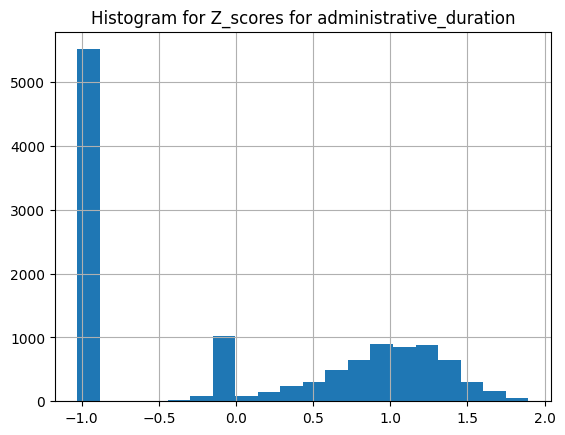

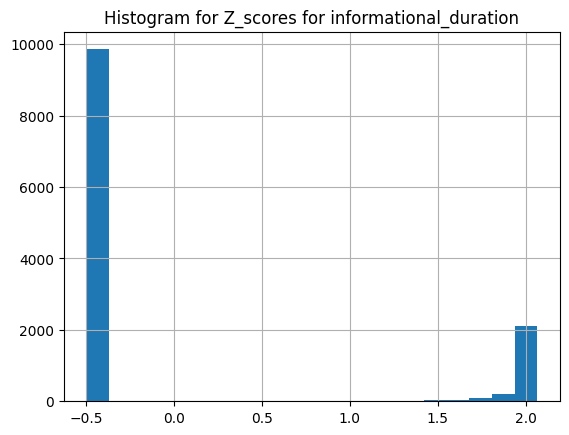

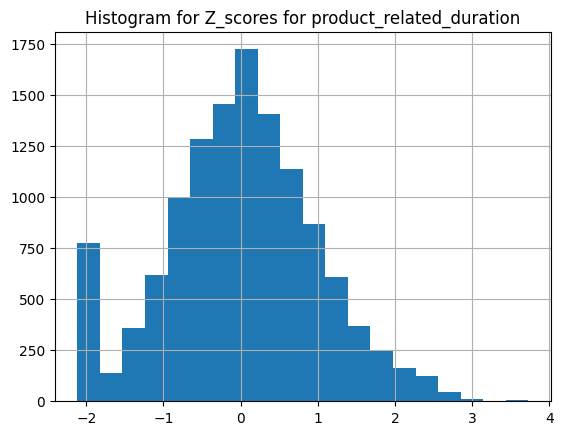

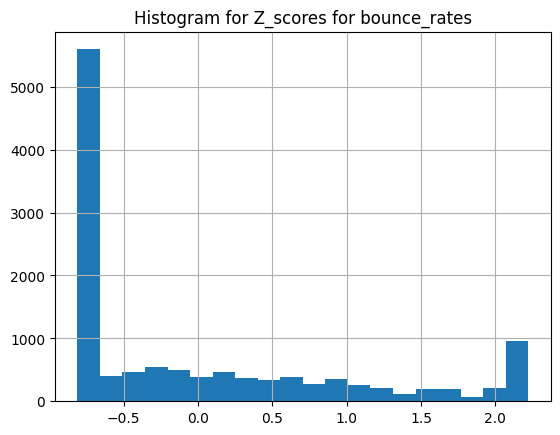

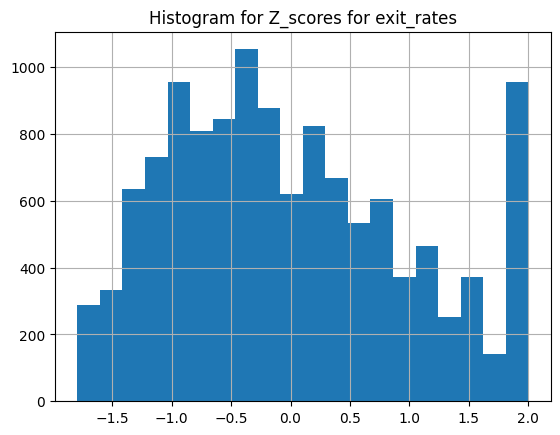

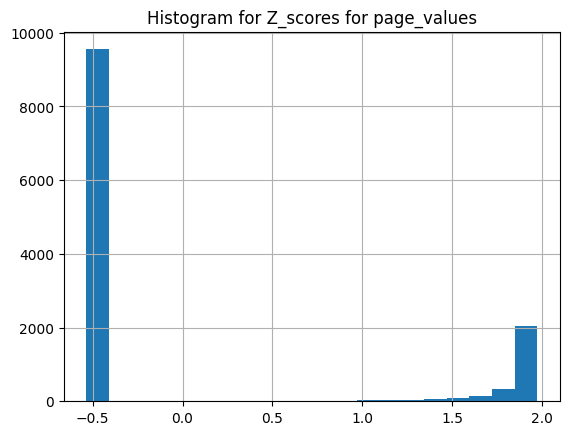

In [15]:
z_scores = {}
for column in numeric_columns:
    z_scores[column] = customer_activity_info.get_zscores(column)
    
# Plot histograms for z_scores for each numeric column
for column in z_scores:
    pd.Series(z_scores[column]).hist(bins = 20)
    plt.title(f'Histogram for Z_scores for {column}')
    plt.show()
    
    

If we consider z_scores greater than +3 or less then -3 as outliers, only product_related_duration
column contains a small number of outliers which will be dropped. 

Add a new column (z_scores for product_related_duration) to the DataFrame:

In [16]:
# Get z_scores for product_related_duration column
product_related_duration_zscores = customer_activity_info.get_zscores('product_related_duration')

# Get shape for the DataFrame before the conversion
print('Shape of the DataFrame before removing the outliers:', customer_activity.shape)

# Add it to the DataFrame as a new column
customer_activity['z_scores'] = product_related_duration_zscores

# Drop outliers from the DataFrame
customer_activity_transform.drop_outliers('z_scores')

# Drop the z_scores column from the DataFrame
customer_activity_transform.drop_column('z_scores')

# Check the shape of the DataFrame
print('Shepe of the DataFrame after removing outliers:', customer_activity.shape)


Shape of the DataFrame before removing the outliers: (12330, 17)
Shepe of the DataFrame after removing outliers: (12321, 17)


Check for collinearity:

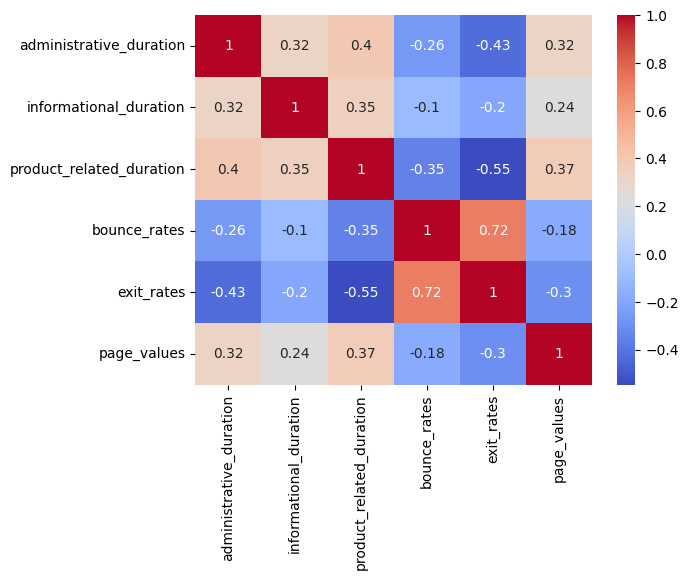

In [17]:
# Create a new DataFrame with only numeric values
numeric_df = customer_activity[numeric_columns]
numeric_df_plotter = plotter.Plotter(numeric_df)
numeric_df_plotter.plot_correlation_matrix()

There does not seem to be any issues with collineaity on this DataFrame.

Save the cleaned DataFrame:

In [18]:
db_utils.save_data(customer_activity, df_cleaned.csv)

NameError: name 'df_cleaned' is not defined

The cleaned DataFrame will be analysed to answer questions in following sections:
- S1 - General overview of the performance of the website
- S2 - Which softwares customers are using to visit the website
- S3 - Investigate the traffic coming to the website
- S4 - Where the website revenue is being generated